In [ ]:
import os
spark_version = 'spark-3.0.2'
os.environ['spark-3.0.2']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.co

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...|        Wireless|          4|    

In [ ]:
#to check the datatypes in the dataframe
df.schema

StructType(List(StructField(marketplace,StringType,true),StructField(customer_id,IntegerType,true),StructField(review_id,StringType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(product_title,StringType,true),StructField(product_category,StringType,true),StructField(star_rating,StringType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true),StructField(review_headline,StringType,true),StructField(review_body,StringType,true),StructField(review_date,StringType,true)))

### Create DataFrames to match tables

In [ ]:
from pyspark.sql.functions import to_date
# Read in the Review dataset as a DataFrame
customer_clean_df = df.dropna()
customer_clean_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...|        Wireless|          4|    

In [ ]:
# Drop duplicates
customer_clean_1_df = customer_clean_df.drop_duplicates()
customer_clean_1_df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   34974850|R10048FCFWVJOH|B002OL2MU4|     471222439|Garmin Portable f...|        Wireless|          5|            0|          0|   N|                N|Garmin Friction M...|The friction moun...| 2011-04-07|
|         US|   30903818|R1008YTRJEH6U7|B00LAHPLTW|     355012266|iPhone 6 case, Ca...|        Wireless|          1|    

In [ ]:
# Create the customers_table DataFrame
customers_df = customer_clean_df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)", "customer_count")
customers_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   46909180|             6|
|   42560427|             7|
|   43789873|             3|
|   22037526|             2|
|   34220092|             2|
+-----------+--------------+
only showing top 5 rows



In [ ]:
customers_df.schema

StructType(List(StructField(customer_id,IntegerType,true),StructField(customer_count,LongType,false)))

In [ ]:
# Create the products_table DataFrame and drop duplicates.
#df.filter("price<20").select("points","country","price").show(5)
products_df = customer_clean_df.select(["product_id","product_title"]).drop_duplicates()
products_df.show(20)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B010LVPJH6|LG G Watch Urbane...|
|B00K5ZNXZ4|Minisuit Sporty A...|
|B00S9RBQOK|iPhone 6 Plus Cas...|
|B0116N7GYC|Selfie Stick, Por...|
|B009UNH0CY|Plantronics Voyag...|
|B00L8GFYAG|Eallc New Quality...|
|B00R3LMTI0|Kaleidio [Wallop ...|
|B011R0VG36|Galaxy Note 4 Cas...|
|B00BXX0QVQ|iKross Black Dual...|
|B00F4AYI2M|Incipio DualPro C...|
|B00GPI3OHC|Retevis H-777 2 W...|
|B00Y9ZUVU6|Tiwkich 2 in 1 Du...|
|B00W65SYHS|LG G4 case, Caseo...|
|B00V5OU6CW|S5 Leather case,P...|
|B00LP3FSH6|Escort Coiled Sma...|
|B00MIO2KRC|Black Box G1W-C C...|
|B00V5FZM0M|   KoKo Cases 5/5S !|
|B00T1KO2TA|iPhone 6 & 6S Cas...|
|B00YU9XOTQ|Galaxy S5 Screen ...|
|B00PI7IGHE|Soyan Latest DZ09...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
products_df.schema

StructType(List(StructField(product_id,StringType,true),StructField(product_title,StringType,true)))

In [ ]:
# Create the review_id_table DataFrame.
# Convert the 'review_date' column to a date datatype with to_date("review_date", 'yyyy-MM-dd').alias("review_date")
review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df.show(10)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
|R3W4P9UBGNGH1U|   16414143|B00YL0EKWE|     852431543| 2015-08-31|
|R15V54KBMTQWAY|   50800750|B00XK95RPQ|     516894650| 2015-08-31|
| RY8I449HNXSVF|   15184378|B00SXRXUKO|     984297154| 2015-08-31|
|R18TLJYCKJFLSR|   10203548|B009V5X1CE|     279912704| 2015-08-31|
|R1NK26SWS53B8Q|     488280|B00D93OVF0|     662791300| 2015-08-31|
|R11LOHEDYJALTN|   13334021|B00XVGJMDQ|     421688488| 2015-08-31|
|R3ALQVQB2P9LA7|   27520697|B00KQW1X1C|     554285554| 2015-08-31|
|R3MWLXLNO21PDQ|   48086021|B00IP1MQNK|     488006702| 2015-08-31|
|R2L15IS24CX0LI|   12738196|B00HVORET8|     389677711| 2015-08-31|
|R1DJ8976WPWVZU|   15867807|B00HX3G6J6|     299654876| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 10 rows



In [ ]:
review_id_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(customer_id,IntegerType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(review_date,DateType,true)))

In [ ]:
# Create the vine_table. DataFrame
vine_df = customer_clean_1_df.select(["review_id","star_rating","helpful_votes","total_votes","vine","verified_purchase"])
vine_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R10048FCFWVJOH|          5|            0|          0|   N|                N|
|R1008YTRJEH6U7|          1|            1|          2|   N|                Y|
|R100F3WWLNCX5S|          5|            0|          0|   N|                Y|
|R100IJSLJ25VPG|          5|            0|          0|   N|                Y|
|R100JPDEL3NLYL|          3|            0|          0|   N|                N|
|R100KWGZ8UZDA0|          1|            0|          1|   N|                Y|
|R100LHWI1PCRDO|          4|            0|          0|   N|                Y|
|R100MJFI7QHR78|          5|            0|          0|   N|                N|
|R100MKHZ325MI7|          4|            2|          2|   N|                Y|
|R100U625Y5RVRJ|          5|            0|          0|   N|     

In [ ]:
vine_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,StringType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#we need to convert the "star_rating" datatype into integer , since we have defined it as an integer in the "vine_table"
#review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
#data_df = data_df.withColumn("Plays", data_df["Plays"].cast(IntegerType()))
#customers_df = customers_df.withColumn("customer_count",col("customer_count").cast("int"))
vine1_df = vine_df.select(["review_id",vine_df["star_rating"].cast("int").alias("star_rating"),"helpful_votes","total_votes","vine","verified_purchase"])
vine1_df .show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R10048FCFWVJOH|          5|            0|          0|   N|                N|
|R1008YTRJEH6U7|          1|            1|          2|   N|                Y|
|R100F3WWLNCX5S|          5|            0|          0|   N|                Y|
|R100IJSLJ25VPG|          5|            0|          0|   N|                Y|
|R100JPDEL3NLYL|          3|            0|          0|   N|                N|
|R100KWGZ8UZDA0|          1|            0|          1|   N|                Y|
|R100LHWI1PCRDO|          4|            0|          0|   N|                Y|
|R100MJFI7QHR78|          5|            0|          0|   N|                N|
|R100MKHZ325MI7|          4|            2|          2|   N|                Y|
|R100U625Y5RVRJ|          5|            0|          0|   N|     

In [ ]:
vine1_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

### Analysing the vine data

In [ ]:
# 1.Filter the Vine DataFrame by those that had 20+ total votes
df1 = vine1_df.filter(vine1_df["total_votes"] >= 20)
df1.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RI7WLRILVK1B0|          5|           31|         38|   N|                Y|
|R31J96IMJ143Z3|          5|           93|         95|   N|                Y|
|R2EX1UWV7ULXR0|          1|            7|         46|   N|                Y|
|R2FG8CTCA2XYLO|          5|           21|         30|   N|                N|
| RAX321OSHA01I|          5|           22|         23|   N|                N|
|R24Z17F1ND33KS|          5|           49|         56|   N|                Y|
|R2STHWTTUQJ4VB|          5|           24|         25|   N|                N|
|R29SS9IM9NPPFE|          4|           37|         41|   N|                Y|
|R2Z9W1GRHRTHP9|          5|           19|         20|   N|                Y|
| RQK68GQIF4R6B|          5|           65|         69|   N|     

In [ ]:
#2.retrieve all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
df2 = df1.filter(df1["helpful_votes"]/df1["total_votes"] >= 0.5)
df2.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RI7WLRILVK1B0|          5|           31|         38|   N|                Y|
|R31J96IMJ143Z3|          5|           93|         95|   N|                Y|
|R2FG8CTCA2XYLO|          5|           21|         30|   N|                N|
| RAX321OSHA01I|          5|           22|         23|   N|                N|
|R24Z17F1ND33KS|          5|           49|         56|   N|                Y|
|R2STHWTTUQJ4VB|          5|           24|         25|   N|                N|
|R29SS9IM9NPPFE|          4|           37|         41|   N|                Y|
|R2Z9W1GRHRTHP9|          5|           19|         20|   N|                Y|
| RQK68GQIF4R6B|          5|           65|         69|   N|                Y|
|R3OX39H666XSNP|          5|           23|         28|   N|     

In [ ]:
#3.Create a new DataFrame or table that retrieves all the rows where a review was written as part of the Vine program (paid), vine == 'Y'.
vine_yes3_df = df2.filter(df2["vine"] == "Y")
vine_yes3_df.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3VBGSOJVCSAC2|          5|           17|         20|   Y|                N|
|R16TM8O9A3C5K7|          4|           95|        116|   Y|                N|
| R9778FXEJZWE8|          5|           34|         36|   Y|                N|
| R54KOWGL1NOPY|          5|          149|        157|   Y|                N|
|R100G36GGWRVFT|          4|          172|        203|   Y|                N|
|R13NLMRBSI0F8Y|          4|           25|         28|   Y|                N|
| RRBM8RTSTA39C|          5|          272|        288|   Y|                N|
| RNP01HW9YISJO|          4|           20|         23|   Y|                N|
|R3IH9V45B5WJY5|          5|          245|        273|   Y|                N|
|R2BX3X17IGCAKI|          3|           19|         32|   Y|     

In [ ]:
#4.Create a new DataFrame and retrieve all the rows where the review was not part of the Vine program (unpaid), vine == 'N'.
vine_No4_df = df2.filter(df2["vine"] == "N")
vine_No4_df.show(10)


+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RI7WLRILVK1B0|          5|           31|         38|   N|                Y|
|R31J96IMJ143Z3|          5|           93|         95|   N|                Y|
|R2FG8CTCA2XYLO|          5|           21|         30|   N|                N|
| RAX321OSHA01I|          5|           22|         23|   N|                N|
|R24Z17F1ND33KS|          5|           49|         56|   N|                Y|
|R2STHWTTUQJ4VB|          5|           24|         25|   N|                N|
|R29SS9IM9NPPFE|          4|           37|         41|   N|                Y|
|R2Z9W1GRHRTHP9|          5|           19|         20|   N|                Y|
| RQK68GQIF4R6B|          5|           65|         69|   N|                Y|
|R3OX39H666XSNP|          5|           23|         28|   N|     

In [ ]:
vine_yes3_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5a.The number of 5-star reviews, and the percentage of 5-star reviews for the paid review vine == Y
Paid_five_star_number = vine_yes3_df[vine_yes3_df['star_rating']== 5].count()
Total_paid_number = vine_yes3_df.count()
Percentage_five_star_vine = float(Paid_five_star_number) / float(Total_paid_number)
print ("Total_paid_number:")
print(Total_paid_number)
print ("Paid_five_star_number:")
print(Paid_five_star_number)
print ("Percentage_five_star_vine:")
print(Percentage_five_star_vine)

Total_paid_number:
613
Paid_five_star_number:
222
Percentage_five_star_vine:
0.3621533442088091


In [ ]:
vine_No4_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5b.The number of 5-star reviews, and the percentage of 5-star reviews for the unpaid review vine == N
Unpaid_five_star_number = vine_No4_df[vine_No4_df['star_rating']== 5].count()
Total_Unpaid_number = vine_No4_df.count()
Percentage_five_star_vine_Unpaid = float(Unpaid_five_star_number) / float(Total_Unpaid_number)
print ("Total_Unpaid_number:")
print(Total_Unpaid_number)
print ("Unpaid_five_star_number:")
print(Unpaid_five_star_number)
print ("Percentage_five_star_vine_Unpaid:")
print(Percentage_five_star_vine_Unpaid)

Total_Unpaid_number:
64934
Unpaid_five_star_number:
30530
Percentage_five_star_vine_Unpaid:
0.47016971078325687


In [ ]:
import matplotlib.pyplot as plt,numpy as np

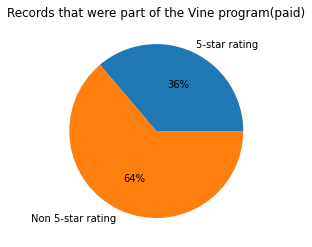

In [ ]:
p=np.array([Percentage_five_star_vine,1-Percentage_five_star_vine])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were part of the Vine program(paid)")
plt.show()

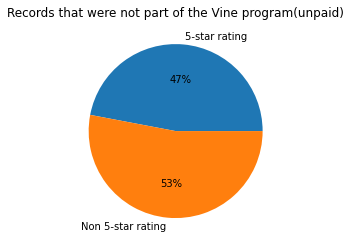

In [ ]:
p=np.array([Percentage_five_star_vine_Unpaid,1-Percentage_five_star_vine_Unpaid])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were not part of the Vine program(unpaid)")
plt.show()